<a href="https://colab.research.google.com/github/nixonleonard/Toxic-Comment-Classification-Project-ML-NLP/blob/main/Toxic_Comment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Library

In [1]:
import os
import re
import nltk
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from wordcloud import WordCloud
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization,  LSTM, Dropout, Bidirectional, Dense, Embedding
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from sklearn.model_selection import train_test_split

nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Import Dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Projects/Toxic Comment Classification/Dataset/train.csv')

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


##Explanatory Data Analysis

In [6]:
df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [7]:
df.drop(['id'], axis = 1)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


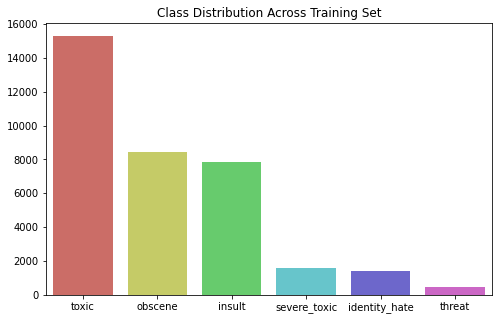

In [8]:
class_distribution = df.iloc[:, 2:].sum().sort_values(axis=0, ascending=False)
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x=class_distribution.index, 
            y=class_distribution.values, 
            ax=ax, 
            palette='hls').set_title('Class Distribution Across Training Set')

plt.show()

In [9]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for label in labels:
  print(df[label].value_counts())

0    144277
1     15294
Name: toxic, dtype: int64
0    157976
1      1595
Name: severe_toxic, dtype: int64
0    151122
1      8449
Name: obscene, dtype: int64
0    159093
1       478
Name: threat, dtype: int64
0    151694
1      7877
Name: insult, dtype: int64
0    158166
1      1405
Name: identity_hate, dtype: int64


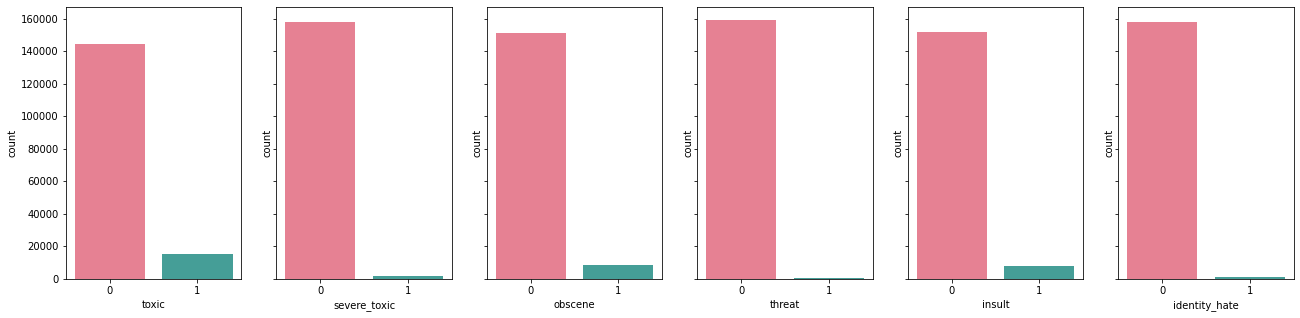

In [10]:
index = 0
fig, axes = plt.subplots(ncols=6,
                         sharex=True,
                         sharey=True,
                         figsize=(22, 5))

for x in df.columns[2:]:
  sns.countplot(x=x, 
               data=df, 
               ax=axes[index],
               palette='husl')
  index += 1

plt.show()

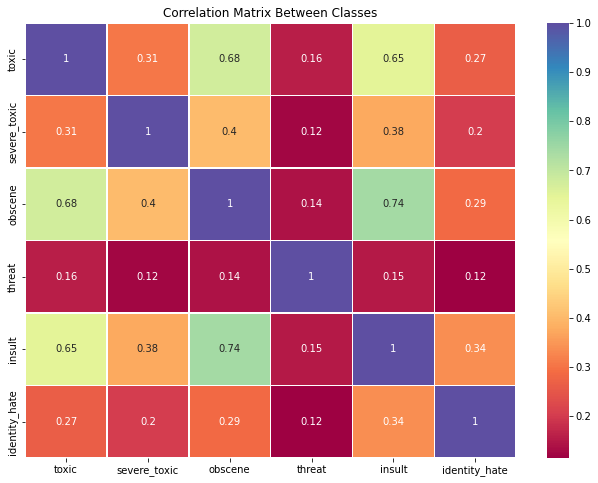

In [11]:
fig, ax = plt.subplots(figsize=(11, 8))
sns.heatmap(df.corr(), 
            annot=True, 
            linewidths=0.5,
            cmap='Spectral',
            ax=ax).set_title('Correlation Matrix Between Classes')

plt.show()

##Data Preprocessing

In [12]:
def view_comments(df):
  for i in range(5):
    print(i + 1, '-', df['comment_text'][i])
    print()

def clean_comment(comment):
  english_stopwords = stopwords.words('english')
  # Set lowercase
  comment = comment.lower()
  # Remove "\n"
  comment = re.sub(r'\n', ' ', comment)
  # Remove "'s"
  comment = re.sub(r'\'s', '', comment)
  # Remove "'ve"
  comment = re.sub(r'\'ve', '', comment)
  # Remove digits but not word containing digits
  comment = re.sub(r'\b[0-9]+\b\s*','', comment)
  # Remove stopwords
  comment = ' '.join([word for word in comment.split() if word not in english_stopwords])
  # Remove punctuations
  comment = re.sub('[%s]' % re.escape(string.punctuation), '', comment)
  # Remove whitespace
  comment = re.sub('\s+',' ', comment)
  return comment

In [13]:
view_comments(df)

1 - Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

2 - D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)

3 - Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.

4 - "
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on 

In [14]:
df['comment_text'] = df['comment_text'].map(lambda x: clean_comment(x))

In [15]:
view_comments(df)

1 - explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since im retired now

2 - daww matches background colour im seemingly stuck with thanks talk january utc

3 - hey man im really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info

4 -  cant make real suggestions improvement wondered section statistics later on subsection types accidents i think references may need tidying exact format ie date format etc later on noone else first preferences formatting style references want please let know appears backlog articles review guess may delay reviewer turns up listed relevant form eg wikipediagoodarticlenominationstransport 

5 - you sir hero chance remember page on



In [16]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [17]:
max_features = 160000
vectorizer = TextVectorization(max_tokens=max_features,
                               output_sequence_length=1600,
                               output_mode='int')

In [18]:
X.values

array(['explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since im retired now',
       'daww matches background colour im seemingly stuck with thanks talk january utc',
       'hey man im really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info',
       ...,
       'spitzer umm theres actual article prostitution ring crunch captain',
       'looks like actually put speedy first version deleted look it',
       ' really think understand came idea bad right away kind community goes you bad ideas go away instead helping rewrite them '],
      dtype=object)

In [19]:
vectorizer.adapt(X.values)

In [20]:
vectorized_text = vectorizer(X.values)

In [21]:
vectorized_text

<tf.Tensor: shape=(159571, 1600), dtype=int64, numpy=
array([[  540,    48,    50, ...,     0,     0,     0],
       [    1,  2404,  1307, ...,     0,     0,     0],
       [  329,   330,    14, ...,     0,     0,     0],
       ...,
       [28702,  7232,  4703, ...,     0,     0,     0],
       [  437,     9,   112, ...,     0,     0,     0],
       [   53,    13,   153, ...,     0,     0,     0]])>

In [22]:
#pipeline deep learning tensor flow
#MCSBAP - Map, Cache, Shuffle, Batch, Prefetch
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [23]:
len(dataset)

9974

In [24]:
train = dataset.take(int(len(dataset)*0.7)) # training take 70% of the dataset
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2)) # validation take 71% - 90% of the dataset
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1)) # testing take 91% - 100% of the dataset

## Modelling

In [30]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(max_features+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [31]:
model.compile(optimizer='Adam', loss='BinaryCrossentropy',)

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          5120032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [33]:
fin_model = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 580s 82ms/step - loss: 0.0615 - val_loss: 0.0459
Epoch 2/5
6981/6981 [==============================] - 586s 84ms/step - loss: 0.0458 - val_loss: 0.0411
Epoch 3/5
6981/6981 [==============================] - 580s 83ms/step - loss: 0.0401 - val_loss: 0.0359
Epoch 4/5
6981/6981 [==============================] - 580s 83ms/step - loss: 0.0353 - val_loss: 0.0302
Epoch 5/5
6981/6981 [==============================] - 584s 84ms/step - loss: 0.0317 - val_loss: 0.0267


In [35]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/Projects/Toxic Comment Classification/ToxicCommentClassifierE5.h5')

In [28]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Projects/Toxic Comment Classification/Dataset/ToxicCommentClassifierE5.h5')

<Figure size 576x360 with 0 Axes>

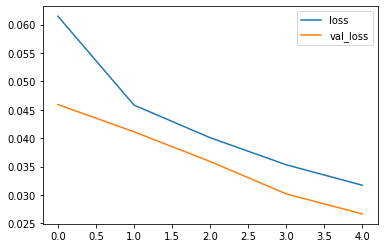

In [36]:
plt.figure(figsize=(8,5))
pd.DataFrame(fin_model.history).plot()
plt.show()

##Predicting Result

In [72]:
text = 'You suck, get out of my face!'
input_text = vectorizer(text)
res = model.predict(np.array([input_text]))
res

array([[0.9967205 , 0.13781078, 0.978013  , 0.00645655, 0.87046295,
        0.03557914]], dtype=float32)

In [67]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [68]:
print('This sentence : \'' + text+ '\' classified as,')
for i in range(6):
    print(df.columns[i+2] + ' : ' + str(round(res[0, i] * 100,2)) + ' %')

This sentence : 'You suck, get out of my face!' classified as,
toxic : 99.67 %
severe_toxic : 13.78 %
obscene : 97.8 %
threat : 0.65 %
insult : 87.05 %
identity_hate : 3.56 %


##Evaluate the model

In [39]:
precision = Precision()
recall = Recall()
acc = CategoricalAccuracy()

#iterate all the bacthes to see the evaluation
for batch in test.as_numpy_iterator(): 
    X_true, y_true = batch
    yhat = model.predict(X_true)
    
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    precision.update_state(y_true, yhat)
    recall.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)
print(f'Precision: {precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{acc.result().numpy()}')

#disini mungkin akurasi tidak besar karena epoch model yang dilakukan hanya 5, karena waktu compile sangat lama, kalau epcoh dinaikan mungkin akurasi juga akan meningkat

Precision: 0.8623229265213013, Recall:0.8640363216400146, Accuracy:0.5145436525344849


##Let's try classify text

In [80]:
while True:
    texts = input('Write a toxic text (type \'quit\' to exit) : ')
    if texts == 'quit':
        break

    input_texts = vectorizer(texts)
    res = model.predict(np.array([input_texts]))

    print('This sentence : \'' + texts + '\' classified as,')
    for i in range(6):
        print(df.columns[i+2] + ' : ' + str(round(res[0, i] * 100,2)) + ' %')
        
    print(' ')

Write a toxic text (type 'quit' to exit) : Hey how are you?
This sentence : 'Hey how are you?' classified as,
toxic : 9.95 %
severe_toxic : 0.0 %
obscene : 0.16 %
threat : 0.67 %
insult : 1.35 %
identity_hate : 0.26 %
 
Write a toxic text (type 'quit' to exit) : Im not that good
This sentence : 'Im not that good' classified as,
toxic : 0.12 %
severe_toxic : 0.0 %
obscene : 0.0 %
threat : 0.0 %
insult : 0.0 %
identity_hate : 0.0 %
 
Write a toxic text (type 'quit' to exit) : You are an idiot
This sentence : 'You are an idiot' classified as,
toxic : 97.68 %
severe_toxic : 1.07 %
obscene : 69.16 %
threat : 0.24 %
insult : 82.81 %
identity_hate : 4.46 %
 
Write a toxic text (type 'quit' to exit) : i hope you will die soon
This sentence : 'i hope you will die soon' classified as,
toxic : 60.99 %
severe_toxic : 0.34 %
obscene : 1.44 %
threat : 14.29 %
insult : 8.71 %
identity_hate : 9.68 %
 
Write a toxic text (type 'quit' to exit) : quit
